using various libraries as this task is not as simple as mnist classification

In [2]:
import os
import pickle

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
from io import BytesIO

from ipywidgets import widgets

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
TRAIN_DIR = 'train'
VAL_DIR   = 'test'

train_dogs_dir   = os.path.join(TRAIN_DIR, 'dogs')
train_cats_dir   = os.path.join(TRAIN_DIR, 'cats')
validate_dogs_dir = os.path.join(VAL_DIR, 'dogs')
validate_cats_dir = os.path.join(VAL_DIR, 'cats')

total samples to train and to validate our result on

In [4]:
print(f"total training dogs images: {len(os.listdir(train_dogs_dir))}")
print(f"total training cats images: {len(os.listdir(train_cats_dir))}")
print(f"total validation dogs images: {len(os.listdir(validate_dogs_dir))}")
print(f"total validation cats images: {len(os.listdir(validate_cats_dir))}")

total training dogs images: 10000
total training cats images: 10000
total validation dogs images: 2500
total validation cats images: 2500


some examples

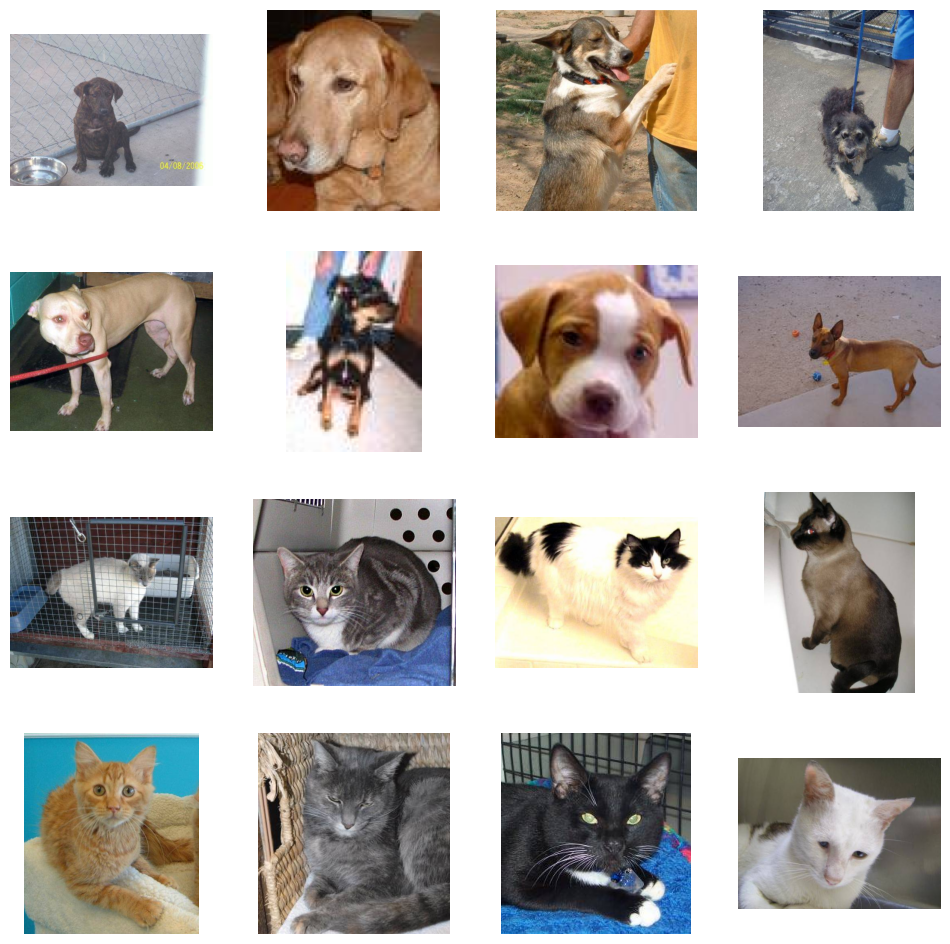

In [5]:
train_dogs_names = os.listdir(train_dogs_dir)
train_cats_names = os.listdir(train_cats_dir)

n_rows = 4
n_cols = 4

fig = plt.gcf()
fig.set_size_inches(n_cols * 3, n_rows * 3)

next_dogs_pix = [os.path.join(train_dogs_dir, fname)
                for fname in random.sample(train_dogs_names, k=8)]
next_cats_pix = [os.path.join(train_cats_dir, fname)
                for fname in random.sample(train_cats_names, k=8)]

for i, img_path in enumerate(next_dogs_pix + next_cats_pix):
    sp = plt.subplot(n_rows, n_cols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

going for 5 layers of Convolution and a 150 by 150 img for the current analysis
using a binary classifier in this with 0-> dogs and 1-> cats 
sigmoid suits best for this task

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

I0000 00:00:1752676098.455579   10129 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5386 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

Data Pre-Processing 

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(150, 150),
    batch_size=128,
    label_mode='binary'
    )

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=(150, 150),
    batch_size=128,
    label_mode='binary'
    )

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


normalization

In [10]:
rescale_layer = tf.keras.layers.Rescaling(1./255)

train_dataset_scaled = train_dataset.map(lambda image, label: (rescale_layer(image), label))
validation_dataset_scaled = validation_dataset.map(lambda image, label: (rescale_layer(image), label))

adding a few more methods to optimize training process and speed

In [11]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset_scaled
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                      )

validation_dataset_final = (validation_dataset_scaled
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

can't forget to not include early stopping callback

In [12]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs.get('loss') <= 0.3 and logs.get('val_loss') <= 0.4 :
            self.model.stop_training = True

In [13]:
history = model.fit(
    train_dataset_final,
    epochs=45,
    validation_data=validation_dataset_final,
    callbacks=[EarlyStopping()],  
    verbose=2
)

Epoch 1/45


I0000 00:00:1752676135.106757   10201 service.cc:152] XLA service 0x7f27300046f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752676135.106773   10201 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-16 19:58:55.129135: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752676135.297544   10201 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1752676140.088510   10201 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 - 21s - 135ms/step - accuracy: 0.6536 - loss: 0.6256 - val_accuracy: 0.7202 - val_loss: 0.5469
Epoch 2/45
157/157 - 6s - 39ms/step - accuracy: 0.7671 - loss: 0.4871 - val_accuracy: 0.7864 - val_loss: 0.4576
Epoch 3/45
157/157 - 6s - 40ms/step - accuracy: 0.8052 - loss: 0.4233 - val_accuracy: 0.7956 - val_loss: 0.4351
Epoch 4/45
157/157 - 6s - 40ms/step - accuracy: 0.8396 - loss: 0.3580 - val_accuracy: 0.8286 - val_loss: 0.3819
Epoch 5/45
157/157 - 6s - 40ms/step - accuracy: 0.8666 - loss: 0.3095 - val_accuracy: 0.8352 - val_loss: 0.3744
Epoch 6/45
157/157 - 6s - 40ms/step - accuracy: 0.8939 - loss: 0.2536 - val_accuracy: 0.8350 - val_loss: 0.3771


metrics visualized

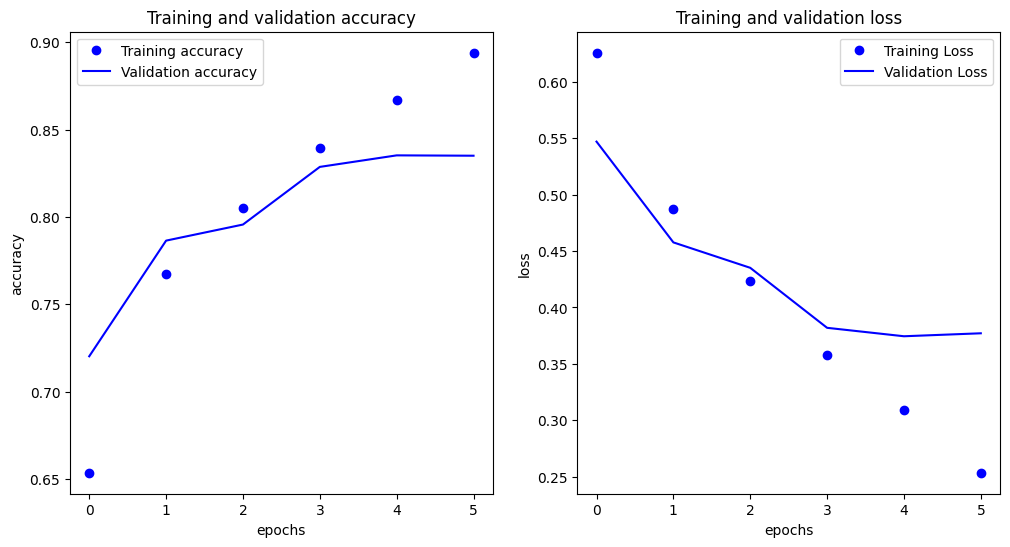

In [14]:
def plot_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()
    
    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()
    
    plt.show()

plot_loss_acc(history)

features transformed through each layer

/tmp/ipykernel_10129/949372650.py:30: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
/tmp/ipykernel_10129/949372650.py:33: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


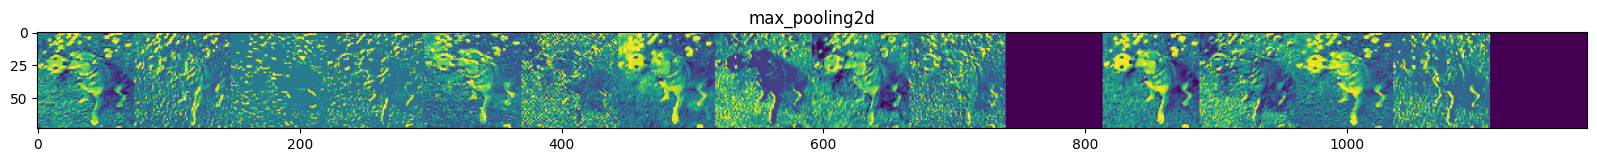

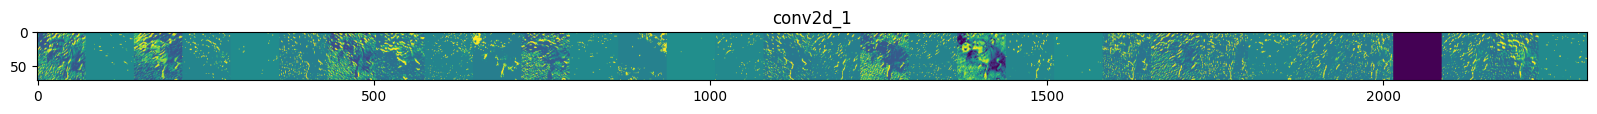

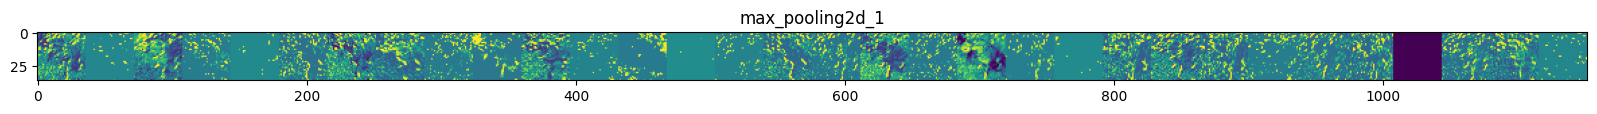

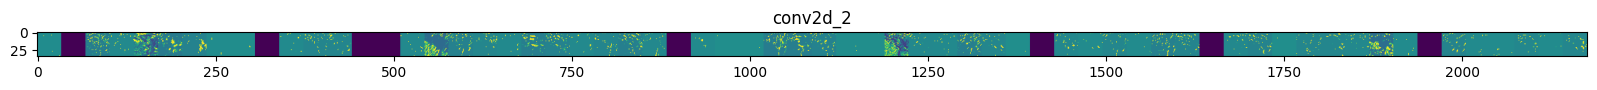

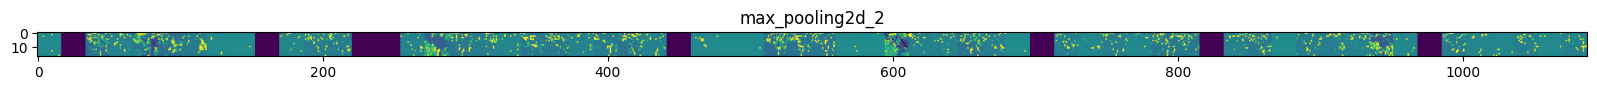

In [15]:
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.inputs, outputs = successive_outputs)

dogs_img_files = [os.path.join(train_dogs_dir, f) for f in train_dogs_names]
cats_img_files = [os.path.join(train_cats_dir, f) for f in train_cats_names]
img_path = random.choice(dogs_img_files + cats_img_files)

img = tf.keras.utils.load_img(img_path, target_size=(150, 150))  
x = tf.keras.utils.img_to_array(img)  
x = x.reshape((1,) + x.shape) 

x = rescale_layer(x)


successive_feature_maps = visualization_model.predict(x, verbose=False)

layer_names = [layer.name for layer in model.layers[1:]]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:

        n_features = feature_map.shape[-1] 

        size = feature_map.shape[1]

        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')

            display_grid[:, i * size : (i + 1) * size] = x

        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

Random Test

In [16]:
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image, verbose=0)[0][0]
    
    with out:
        if prediction > 0.5:
            print(filename + " is a dog")
        else:
            print(filename + " is a cat")


def on_upload_change(change):
    
    items = change.new
    for item in items: 
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)

uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

In [19]:
with open('model.pkl','wb') as f:
    pickle.dump(history.history , f)